<a href="https://colab.research.google.com/github/Bitdribble/dlwpt-code/blob/master/colab/PyTorchCh8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Telling birds from airplanes: Learning from images using convolutions ([Deep Learning with PyTorch](https://pytorch.org/assets/deep-learning/Deep-Learning-with-PyTorch.pdf), Chap. 8)

In [ ]:
import datetime
from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

torch.set_printoptions(edgeitems=2, linewidth=75) # Simplifies print output of tensors
torch.manual_seed(123) # Fixed seed for reproducibility

In [ ]:
# Data preparation
data_path = '.'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


In [ ]:
# Normalize data
transformed_cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468), # Mean per channel, precomputed in Chap 7
                             (0.2470, 0.2435, 0.2616)) # Stddev per channel
    ]))
transformed_cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [ ]:
# Restrict data from 10 categories to airplanes (category 0) and birds (category 2)
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']

cifar2 = [(img, label_map[label]) for img, label in transformed_cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in transformed_cifar10_val if label in [0, 2]]


In [ ]:
# Instead of linear layers, use 'convolution layers'. The convolution matrix
# has weights as below (also has bias, but ignore that for now):
#
# weight = torch.tensor([[w00, w01, w02],
#                        [w10, w11, w12],
#                        [w20, w21, w22]])
#
# This is called the 'kernel'. 
# Assume a 1-channel, MxN image:
#
# image = torch.tensor([[i00, i01, i02, i03, ..., i0N],
#                       [i10, i11, i12, i13, ..., i1N],
#                       [i20, i21, i22, i23, ..., i2N],
#                       [i30, i31, i32, i33, ..., i3N],
#                       ...
#                       [iM0, iM1m iM2, iM3, ..., iMN]])
#
# We can compute an element of the output image (without bias) as:
#
# [[o00, o01, ...],
#  [o10, o11, ...],
#   ...
#
# where
#
# o11 = i11 * w00 + i12 * w01 + i13 * w02 + 
#       i21 * w10 + i22 * w11 + i23 * w12 +
#       i31 * w20 + i32 * w21 + i33 * w22
#
# In essence:
# - We 'pad' kernel and image with 0-valued rows and columns
# - Steps to obtain oij:
#   - Translate the kernel by (i, j), and transpose it
#   - Multiply image with translated, transposed kernel, and take sum of elements

![](https://drive.google.com/uc?export=view&id=1bSJk77_mcn_fytNb_HgYBapXrMyf5vg1)

- Just like the elements in the weight matrix of nn.Linear, the weights in the kernel are not known in advance, but they are initialized randomly and updated
through backpropagation. 

- The same kernel, and thus each weight in the kernel, is reused across the whole image. 

- With a convolution layer, the number of parameters depends not on the number of pixels in the image, as was the case in our fully connected model, but rather on the size of the convolution kernel.

Summarizing, by switching to convolutions, we get:
- Local operations on a neighborhood
- Translation invariance
- Models with a lot fewer parameters

In [ ]:
# - Image is RGB, with 3 input channels
# - Pick arbitrary number of output channels (16). This is needed b/c
# of 'lottery ticket hypothesis' (saying that some channels will end up being useless!)
# - Kernel size is 3 (shorthand for 3x3). It is square size, but could be rectangular.
conv = nn.Conv2d(3, 16, kernel_size=3)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [ ]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [ ]:
# We need to add the zeroth batch dimension with
# unsqueeze if we want to call the conv module with one input image, since nn.Conv2d
# expects a B × C × H × W shaped tensor as input
img, _ = cifar2[0] # First image in cifar2 dataset
output = conv(img.unsqueeze(0)) # Apply convolution
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


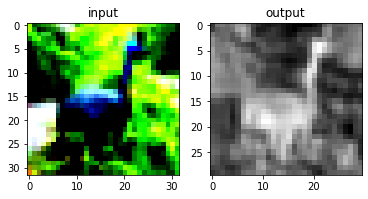

In [ ]:
# Image before and after conv
subplot = plt.subplot(1, 2, 1)
subplot.set_title("input")
plt.imshow(img.permute(1, 2, 0), cmap='gray') # Convert image from C x H x W to H x W x C
subplot = plt.subplot(1, 2, 2)
subplot.set_title("output")
plt.imshow(output[0, 0].detach(), cmap='gray') # Use detach() to remove computation graph
plt.show()

In [ ]:
# output size is 30x30 instead of 32x32 b/c 
# by default pytorch will slide the convolution kernel
# only within the image (and the center of the conv kernel
# will not reach the end rows/colums)
img.size(),output.size()

(torch.Size([3, 32, 32]), torch.Size([1, 16, 30, 30]))

In [ ]:
# However, PyTorch gives us the possibility of padding the image
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1) # Now with padding and 1 output channel instead of 16

output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

![](https://drive.google.com/uc?export=view&id=1PGZnYrlzMHbcEVmXYhyY6knvlebUv6q1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


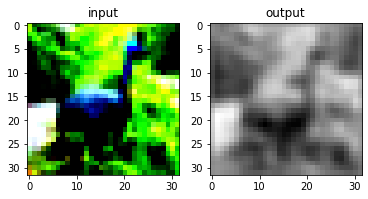

In [ ]:
# Detecting features with convolutions
#
# Zero out the bias, and set the kernel to equal weights
with torch.no_grad():
  conv.bias.zero_()
with torch.no_grad():
  conv.weight.fill_(1.0 / 9.0)

output = conv(img.unsqueeze(0))

# The filter produces a blurred version of the image. With equal weights, every pixel of 
# the output is the average of a neighborhood
subplot = plt.subplot(1, 2, 1)
subplot.set_title("input")
plt.imshow(img.permute(1, 2, 0), cmap='gray')
subplot = plt.subplot(1, 2, 2)
subplot.set_title("output")
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


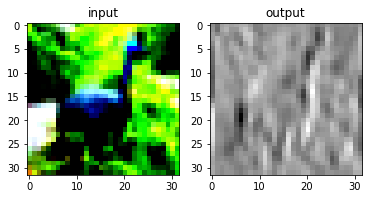

In [ ]:
# Try new kernel that gives difference between next column and prev column
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
with torch.no_grad():
  conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                 [-1.0, 0.0, 1.0],
                                 [-1.0, 0.0, 1.0]])
  conv.bias.zero_()

output = conv(img.unsqueeze(0))

# This kernel detects vertical edges
subplot = plt.subplot(1, 2, 1)
subplot.set_title("input")
plt.imshow(img.permute(1, 2, 0), cmap='gray')
subplot = plt.subplot(1, 2, 2)
subplot.set_title("output")
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

In [ ]:
# We could build lots more elaborate filters, such as for detecting horizontal or diagonal edges, or cross-
# like or checkerboard patterns, where “detecting” means the output has a high magni-
# tude. In fact, the job of a computer vision expert has historically been to come up with
# the  most  effective  combination  of  filters  so  that  certain  features  are  highlighted  in
# images and objects can be recognized.
#
# With deep learning, we let kernels be estimated from data in whatever way the dis-
# crimination is most effective: for instance, in terms of minimizing the negative cross-
# entropy loss between the output and the ground truth. From this angle, 
# the job of a convolutional neural network is to estimate the ker-
# nel of a set of filter banks in successive layers that will transform a multichannel image
# into  another  multichannel  image,  where  different  channels  correspond  to  different
# features (such as one channel for the average, another channel for vertical edges, and
# so on). Figure below shows how the training automatically learns the kernels. 

![](https://drive.google.com/uc?export=view&id=17iDBagvo6-6pt1aMy81Gj7Z4BcduG7I8)

In [ ]:
# Convolutions achieve locality and translation invariance. Small convolution 
# kernels are recommended, 3x3 or 5x5. But what about detecting 'global' features?
#
# Don't want to use large conv kernels, say 32x32, b/c it's inefficient.
# 
# Idea: use downsampling layer. We stack one convolution after the other and 
# at the same time downsampling the image between successive convolutions.
#
# Downsampling could be done in different ways. Scaling an image by half is
# the equivalent of taking four neighboring pixels as input and producing 
# one pixel as output. We could:
# - Average the four pixels. This average pooling was a common approach early on but
#   has fallen out of favor somewhat.
# - Take the maximum of the four pixels. This approach, called max pooling, is currently
#   the  most  commonly  used  approach,  but  it  has  a  downside  of  discarding  the
#   other three-quarters of the data.
# - Perform a strided convolution, where only every Nth pixel is calculated. A 3 × 4 convolu-
#   tion with stride 2 still incorporates input from all pixels from the previous layer.
#   The  literature  shows  promise  for  this  approach,  but  it  has  not  yet  supplanted
#   max pooling.
#
# We use max pooling.

![](https://drive.google.com/uc?export=view&id=1scpsEZYYIotuu8bFDTsXGTbaaiHmLmw4)

In [ ]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

![](https://drive.google.com/uc?export=view&id=1Ya2EIe8uvy4n8B-T__-oQCZ-OuUJgZnG)

In [ ]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.Tanh(),

    nn.MaxPool2d(2),
    nn.Conv2d(16, 8, kernel_size=3, padding=1),
    nn.Tanh(),

    nn.MaxPool2d(2),
    # ... More layers will be added here later
)

# 3x32x32 -> 16x32x32 # giving the network a  chance  to  generate  16  independent  
#                     # features  that  operate  to  (hopefully)  discrimi-
#                     # nate low-level features of birds and airplanes.
#         -> 16x16x16 # maxpool downsampling from 32x32 to 16x16 images
#         ->  8x16x16 # down to 8 channels for 16x16 images
#         ->    8x8x8 # downsampling to 8x8 images

# Complete the network with fully connected layers
model = nn.Sequential(                          # Layer output:
    nn.Conv2d(3, 16, kernel_size=3, padding=1), # 16x32x32
    nn.Tanh(),
    nn.MaxPool2d(2),                            # 16x16x16

    nn.Conv2d(16, 8, kernel_size=3, padding=1), # 8x16x16
    nn.Tanh(),
    nn.MaxPool2d(2),                            # 8x8x8

    nn.Flatten(), # Needed to convert 8x8x8 to 8*8*8

    nn.Linear(8*8*8, 32), # 32
    nn.Tanh(),

    nn.Linear(32, 2) # 2 (planes, birds)
    )

# The size of the linear layer is dependent on the expected size of the output 
# of MaxPool2d: 8×8×8 = 512. Let’s count the number of parameters for this small model:

numel_list = [p.numel() for p in model.parameters() if p.requires_grad == True]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [ ]:
# That’s very reasonable for a limited dataset of such small images. In order to increase
# the capacity of the model, we could increase the number of output channels for the
# convolution layers (that is, the number of features each convolution layer generates),
# which would lead the linear layer to increase its size as well.

![](https://drive.google.com/uc?export=view&id=114aiMy8s6OC4BVNkP6hWEkW8szfRFMOX)

In [ ]:
# model forward pass
model(img.unsqueeze(0))

tensor([[0.0975, 0.1355]], grad_fn=<AddmmBackward0>)

In [ ]:
# Writing the network as submodule
#
# When  we  want  to  build  models  that  do  more  complex  things  than  just  applying 
# one layer after another, we need to leave nn.Sequential for something that gives us
# added flexibility. PyTorch allows us to use any computation in our model by subclass-
# ing nn.Module.
#
# In order to subclass nn.Module, at a minimum we need to define a forward function
# that takes the inputs to the module and returns the output. This is where we define our
# module’s computation. The name forward here is reminiscent of a distant past, when
# modules  needed  to  define  both  the  forward  and  backward  passes. 
#
# With nn.Module, if we use standard torch operations, autograd will take care of the
# backward pass automatically; and indeed, an nn.Module never comes with a backward API.
#
# Typically, our computation will use other modules — which could be premade, like convolutions, or
# custom. To include these submodules, we typically define them in the constructor
# __init__ and assign them to self for use in the forward function. They will, at the
# same time, hold their parameters throughout the lifetime of our module. Note that you
# need to call super().__init__() before you can do that (or PyTorch will remind you).
#
# In the constructor, we  instantiate  all  the  nn.Conv2d, nn.Linear, and so on 
# that we previously passed to nn.Sequential,
# and then use their instances one after another in forward().

class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
    self.act1 = nn.Tanh()

    self.pool1 = nn.MaxPool2d(2)
    self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
    self.act2 = nn.Tanh()

    self.pool2 = nn.MaxPool2d(2)
    self.fc1 = nn.Linear(8*8*8, 32)
    self.act3 = nn.Tanh()

    self.fc2 = nn.Linear(32, 2)

  def forward(self, x):
    out = self.pool1(self.act1(self.conv1(x)))
    out = self.pool2(self.act2(self.conv2(out)))
    out = out.view(-1, 8*8*8) # In place of nn.Flatten()
    out = self.act3(self.fc1(out))
    out = self.fc2(out)
    return out

# We leave the batch dimension as –1 in the call to view, since we
# don’t know how many samples will be in the batch

# Architecture comments:
#
# 1. The size of our intermediate values is generally shrinking. This is done 
# by reducing the number of channels in the convolutions, by
# reducing the number of pixels through pooling, and by having an output dimension
# lower than the input dimension in the linear layers. This is a common trait of
# classification networks. However, in many popular architectures like the ResNets, 
# the reduction is achieved by pooling in the spatial resolution, but the number of  
# channels increases (still resulting in a reduction in size). It seems that 
# our pattern of fast information reduction works well with networks of limited depth and 
# small images; but for deeper networks, the decrease is typically slower.
#
# 2. The initial layer is special in that it is the only one drastically increasing the output size. 
# This can be thought as an embedding in a higher dimensional space followed by doing simpler
# layer. This is called the 'kernel trick'.

In [ ]:
# Assigning an instance of nn.Module to an attribute in an nn.Module, as
# we did in the earlier constructor, automatically registers the module as a submodule.
# 
# The submodules must be top-level attributes, not buried inside list or
# dict instances! Otherwise the optimizer will not be able to locate the sub-
# modules (and, hence, their parameters). For situations where your model
# requires a list or dict of submodules, PyTorch provides nn.ModuleList and nn.ModuleDict.
#
# This allows Net to have access to the parameters of its submodules without further
# action by the user, as model.parameters()
#
# Whether using Sequential() or Module() type modules, 
# parameters are accessed as model.parameters()
model = Net()
numel_list = [p.numel() for p in model.parameters() if p.requires_grad == True]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [ ]:
# Here, 432 = 3 input channels x 9 conv kernel size x 16 out channels for weights,
# 16 = number of biases
# 1152 = 16 in channels x 9 conv kernel size x 8 out channels,
# 8 = number of biases,
# 16,384 = 8x8x8 inputs x32 outputs for weights,
# 32 = number of biases,
# 64 = 32 inputs x2 outputs,
# 2 = number of biases

In [ ]:
import datetime
import torch.nn.functional as F


In [ ]:
# - Feed the inputs through the model (the forward pass).
# - Compute the loss (also part of the forward pass).
# - Zero any old gradients.
# - Call  loss.backward()  to  compute  the  gradients  of  the  loss  with  respect  to  all
#   parameters (the backward pass).
# - Have the optimizer take a step in toward lower loss.
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader, log_epochs=0):
  for epoch in range(n_epochs):
    loss_train = 0.0
    for imgs, labels in train_loader: # Loops over our dataset in the batches the data loader creates for us
      outputs = model(imgs) # Feed a batch through the model
      loss = loss_fn(outputs, labels) # ...compute the loss we wish to minimize

      optimizer.zero_grad() # After getting rid of the gradients from the last round ...
      loss.backward() # ... performs the backward step. That is, we compute the gradients of all parameters we 
                      # want the network to learn.
      optimizer.step() # Update the model

      loss_train += loss.item() # Sums the losses we saw over all batches in the epoch.
                                # We transform the loss to a Python number with .item(), 
                                # to escape the gradients.

    if log_epochs is not 0 and ((epoch+1) % log_epochs == 0 or (epoch+1) == n_epochs):
      print(f"{datetime.datetime.now()} Epoch {epoch+1}, "
            f"Training loss {loss_train / len(train_loader):.3f}")
      # Training loss divides by the length of the training data loader to get 
      # the average loss per batch. This is a more intuitive measure to display than the sum.

# The DataLoader batches up the examples of our cifar2 dataset. 
# Shuffling randomizes the order of the examples from the dataset.
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

model = Net() # Instantiates our network ...
optimizer = optim.SGD(model.parameters(), lr=1e-2) # ... the stochastic gradient 
                                                   # descent optimizer we have 
                                                   # been working with ..

loss_fn = nn.CrossEntropyLoss() # ... and the cross entropy loss

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,

    loss_fn = loss_fn,
    train_loader = train_loader,
    log_epochs=10
)

2022-01-09 14:45:53.417711 Epoch 10, Training loss 0.328
2022-01-09 14:46:32.224949 Epoch 20, Training loss 0.289
2022-01-09 14:47:11.222132 Epoch 30, Training loss 0.264
2022-01-09 14:47:50.444621 Epoch 40, Training loss 0.241
2022-01-09 14:48:29.368129 Epoch 50, Training loss 0.226
2022-01-09 14:49:08.427316 Epoch 60, Training loss 0.207
2022-01-09 14:49:47.412806 Epoch 70, Training loss 0.193
2022-01-09 14:50:26.439146 Epoch 80, Training loss 0.182
2022-01-09 14:51:05.365394 Epoch 90, Training loss 0.166
2022-01-09 14:51:44.446271 Epoch 100, Training loss 0.153


In [ ]:
# Measuring accuracy
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

def validate(model, train_loader, val_loader):
  for name, loader in [("train", train_loader), ("val", val_loader)]:
    correct = 0
    total = 0
    with torch.no_grad(): # We do not want gradients here, as we will not want to update the parameters.
      for imgs, labels in loader:
        outputs = model(imgs)
        _, predicted = torch.max(outputs, dim=1) # Gives us the index of the highest value as output

        total += labels.shape[0] # Counts the number of examples, so total is increased by the batch size

        # Comparing the predicted class that had the maximum probability and the ground-truth
        # labels, we first get a Boolean array. Taking the sum gives the number of items in the batch
        # where the prediction and ground truth agree.
        correct += int((predicted == labels).sum())

    print(f"Accuracy {name}: {correct / total:.2f}")

validate(model, train_loader, val_loader)

Accuracy train: 0.94
Accuracy val: 0.90


In [ ]:
# Saving and loading the model
torch.save(model.state_dict(), "birds_vs_airplanes.pt")

# We will have to make sure we don’t change the definition of Net between saving and 
# later loading the model state.
loaded_model = Net()

loaded_model.load_state_dict(torch.load("birds_vs_airplanes.pt"))

<All keys matched successfully>

In [ ]:
# Training on the GPU
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [ ]:
# Amend the training loop by moving tensors to gpu
def training_loop_gpu(n_epochs, optimizer, model, loss_fn, train_loader, log_epochs=0):
  for epoch in range(1, n_epochs + 1):
    loss_train = 0.0

    for imgs, labels in train_loader:
      imgs = imgs.to(device=device) # Move to gpu
      labels = labels.to(device=device) # Move to gpu

      outputs = model(imgs)
      loss = loss_fn(outputs, labels)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      loss_train += loss.item()

    if log_epochs is not 0 and ((epoch+1) % log_epochs == 0 or (epoch+1) == n_epochs):
      print(f"{datetime.datetime.now()} Epoch {epoch+1}, "
            f"Training loss {loss_train / len(train_loader):.3f}")

def validate_gpu(model, train_loader, val_loader):
  for name, loader in [("train", train_loader), ("val", val_loader)]:
    correct = 0
    total = 0
    with torch.no_grad(): 
      for imgs, labels in loader:
        imgs = imgs.to(device=device) # Move to gpu
        labels = labels.to(device=device) # Move to gpu

        outputs = model(imgs)
        _, predicted = torch.max(outputs, dim=1) 

        total += labels.shape[0]
        correct += int((predicted == labels).sum())


    print(f"Accuracy {name}: {correct / total:.2f}")

In [ ]:
model_gpu = Net().to(device=device)
optimizer = optim.SGD(model_gpu.parameters(), lr=1e-2)
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

loss_fn = nn.CrossEntropyLoss()
training_loop_gpu(
    n_epochs = 100,
    optimizer = optimizer,
    model = model_gpu,

    loss_fn = loss_fn,
    train_loader = train_loader,
    log_epochs = 10
)

2022-01-09 14:53:13.936882 Epoch 10, Training loss 0.341
2022-01-09 14:53:19.766887 Epoch 20, Training loss 0.301
2022-01-09 14:53:25.612316 Epoch 30, Training loss 0.277
2022-01-09 14:53:31.415174 Epoch 40, Training loss 0.257
2022-01-09 14:53:37.264388 Epoch 50, Training loss 0.235
2022-01-09 14:53:43.087479 Epoch 60, Training loss 0.222
2022-01-09 14:53:48.907270 Epoch 70, Training loss 0.206
2022-01-09 14:53:54.754319 Epoch 80, Training loss 0.193
2022-01-09 14:54:00.578399 Epoch 90, Training loss 0.181
2022-01-09 14:54:06.423398 Epoch 100, Training loss 0.168


In [ ]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

validate_gpu(model_gpu, train_loader, val_loader)

Accuracy train: 0.93
Accuracy val: 0.89
